In [119]:
%load_ext autotime
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import matplotlib.pyplot as plt

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.57 ms


In [120]:
import sys
sys.path.extend(["../"])

time: 446 µs


In [121]:
from sklearn.model_selection import train_test_split
from core.tools.data_import import *
from core.tools.time_series import *
from constants import *

time: 544 µs


In [122]:
from pprint import pprint
pprint(UNRATE_DIR)
file_dir_selected = input("Select Directory ")

{'EC2': '/home/ec2-user/code/AnnEconForecast/data/UNRATE.csv',
 'MAC': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv'}
Select Directory EC2
time: 2.82 s


In [123]:
df = load_dataset(UNRATE_DIR[file_dir_selected])
df_d1 = differencing(df, periods=1, order=2)
LAGS = 48
df_d1.head()

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


,UNRATE_period1_order2
DATE,
1948-01-01,NaN
1948-02-01,NaN
1948-03-01,-0.2
1948-04-01,-0.3
1948-05-01,-0.3


time: 18.4 ms


In [126]:
X_raw, y_raw = gen_supervised_sequence(
    df_d1, LAGS, "UNRATE_period1_order2", sequential_label=True)

Total 799 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (799, 48, 1), y shape = (799, 48, 1)
time: 58.1 ms


In [127]:
X_raw = X_raw.reshape(-1, LAGS,)
y_raw = y_raw.reshape(-1, LAGS,)
# y_raw = y_raw.reshape(-1, 1, 1)

time: 628 µs


In [128]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

time: 1.79 ms


In [129]:
X_scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
y_scaler = sklearn.preprocessing.StandardScaler().fit(y_train)

time: 2.08 ms


In [130]:
tx = lambda target: X_scaler.transform(target)
ty = lambda target: y_scaler.transform(target)

X_train = tx(X_train)
X_test = tx(X_test)
X_val = tx(X_val)

y_train = ty(y_train)
y_test = ty(y_test)
y_val = ty(y_val)

time: 2.51 ms


In [131]:
print(np.std(X_train))
print(np.std(y_train))

1.0
1.0
time: 1.88 ms


In [132]:
# Expand dimension so it fits the RNN input place holder.
# (Num_Sample, )
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

time: 649 µs


In [133]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

time: 772 µs


In [134]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (511, 48, 1)
y_train shape: (511, 48, 1)
X_test shape: (160, 48, 1)
y_test shape: (160, 48, 1)
X_validation shape: (128, 48, 1)
y_validation shape: (128, 48, 1)
time: 826 µs


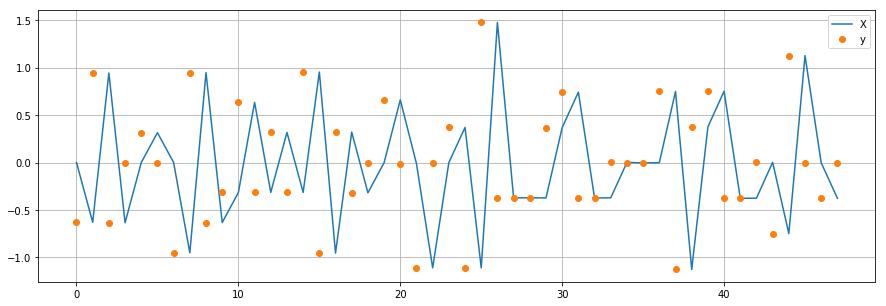

time: 185 ms


In [135]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[-1])
plt.plot(y_train[-1], "o")
plt.legend(["X", "y"])
plt.grid(True)
plt.show()

In [136]:
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_neurons = 64
# Number of output series
num_outputs = 1
learning_rate = 0.03
epochs = 1000
# Training Settings
REPORT_PERIOD = 100

time: 617 µs


In [137]:
tf.reset_default_graph()
# setting up
X = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_inputs],
    name="Input_placeholder")
# y = tf.placeholder(
#     tf.float32,
#     [None, num_time_steps, num_outputs],
#     name="Output_placeholder")
y = tf.placeholder(
    tf.float32,
    [None, None, num_outputs],
    name="Output_placeholder")

time: 3.46 ms


In [138]:
# Build RNN.
cell = tf.contrib.rnn.LSTMCell(
    num_units=num_neurons
)
    
rnn_output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# stacked_rnn_output = tf.reshape(rnn_output, [-1, num_neurons])

# stacked_outputs = tf.layers.dense(stacked_rnn_output, num_outputs)
# outputs = tf.reshape(stacked_outputs, [-1, num_time_steps, num_outputs])
outputs = tf.layers.dense(rnn_output, num_outputs)
last_output = outputs[:, -1]

time: 119 ms


In [139]:
# Operators
loss = tf.reduce_mean(tf.square(outputs - y))
# loss = tf.reduce_mean(tf.square(last_output - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

time: 248 ms


In [140]:
def progbar(curr, total, full_progbar):
    frac = curr/total
    filled_progbar = round(frac*full_progbar)
    print('\r', '#'*filled_progbar + '-'*(full_progbar-filled_progbar), '[{:>7.2%}]'.format(frac), end='')

time: 719 µs


In [141]:
hist = {"train": [], "val": []}
with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        progbar(e, epochs-1, epochs//10)
        sess.run(train,
                 feed_dict={X: X_train, y: y_train})
        if e % REPORT_PERIOD == 0:
            train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
            val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
            hist["train"].append(train_mse)
            hist["val"].append(val_mse)
            print(f"\nIteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}")
    
    gen_pred = lambda src: outputs.eval(feed_dict={X: src})[:,-1]
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    

 ---------------------------------------------------------------------------------------------------- [  0.00%]
Iteration [0], Training MSE 0.9141995; Validation MSE 0.4644309
 ##########------------------------------------------------------------------------------------------ [ 10.01%]
Iteration [100], Training MSE 0.2054850; Validation MSE 0.3670370
 ####################-------------------------------------------------------------------------------- [ 20.02%]
Iteration [200], Training MSE 0.0789273; Validation MSE 0.3956092
 ##############################---------------------------------------------------------------------- [ 30.03%][ 23.52%]
Iteration [300], Training MSE 0.0604980; Validation MSE 0.4332404
 ########################################------------------------------------------------------------ [ 40.04%]##################################------------------------------------------------------------------ [ 33.83%]###################################-------------------------

In [142]:
# clean = lambda x: np.squeeze(x[:, -1: ])
# pred_train = clean(pred_train)
# pred_val = clean(pred_val)
# pred_test = clean(pred_test)

time: 265 µs


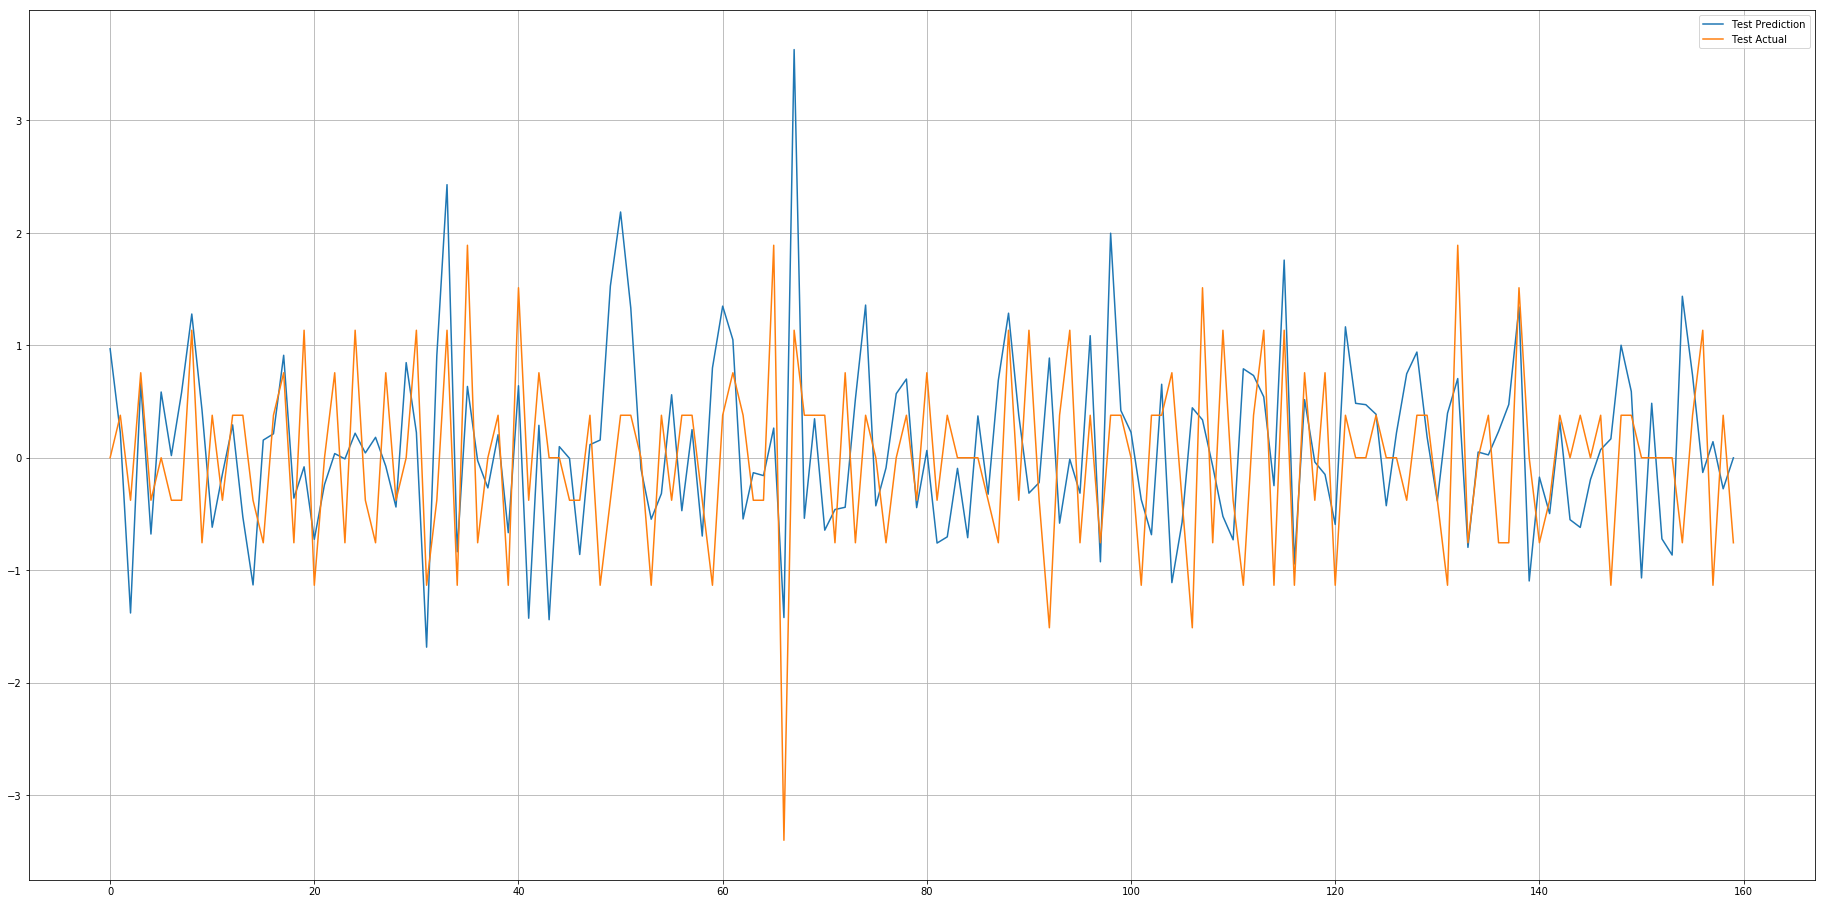

time: 618 ms


In [143]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_test[:,-1]))
plt.plot(np.squeeze(y_test[:,-1]))
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

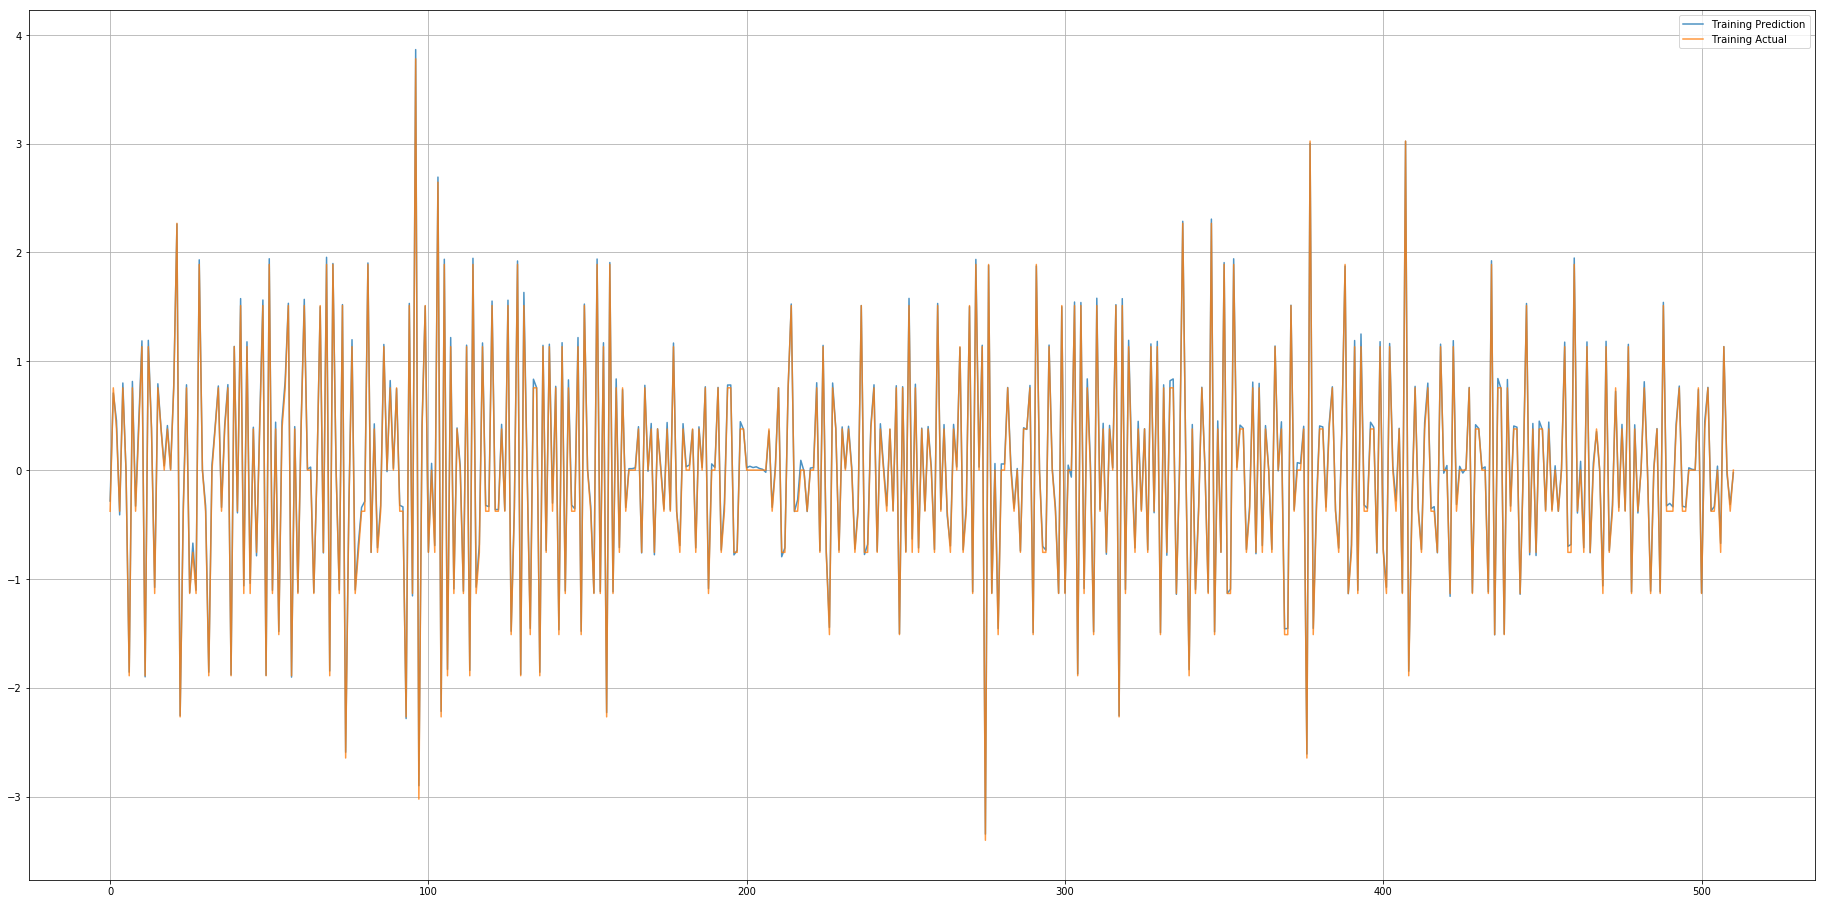

time: 731 ms


In [144]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_train), alpha=0.8)
plt.plot(np.squeeze(y_train[:,-1]), alpha=0.8)
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

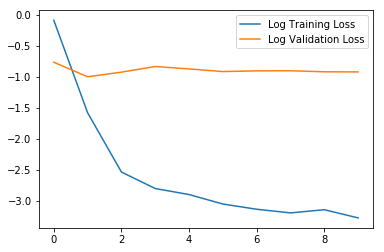

time: 117 ms


In [145]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()